<h1> Parameter Tuning
    
    Look for better optimizer

# Importing libraries:

In [16]:
!pip install pandas
!pip install sklearn
!pip install matplotlib

import pandas as pd;
import numpy as np;
import sklearn
import matplotlib.pyplot as plt

# parameters
steps = 96
n_hidden = 1
units = 150
batch_size = 96

# months to evaluate model on
date = 2018090000

# for later use
features_num = 14

# lists to append results
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []
y_pred_list = []
time_count = []

# Import data; set X and y; fill nan values and split in test and training  data:

In [17]:
# import data
data = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# 2018 data
data = data.loc[data.index > date, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values
data.fillna(method = 'ffill', inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [18]:
from sklearn.preprocessing import MinMaxScaler

# data scaling  (including offer (y))
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing the Keras libraries and packages:

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

# Need to process data with spike occurences the same way as features and offers:
(Required to evaluate predictions in both normal regions and spike regions)

In [20]:
# download data for shaded area
data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# make sure shaded area will correspond to values outputed by LSTM
data.reset_index(drop = True, inplace = True)

# fill_nan is already made - so lets split data into test and train
from sklearn.model_selection import train_test_split

# divide data into train and test 
shade_train, shade_test = train_test_split(
         data, test_size = 0.15, shuffle = False)

# reset index of testing data
shade_test.reset_index(drop = True, inplace = True)

# function to split data into correct shape for RNN
def split_data(shade_test, steps):
    y_spike_occ = list()
    upper_lim = list()
    lower_lim = list()
    for i in range(steps, len(shade_test.index)):
        y_spike_occ.append(shade_test['spike_occurance'][i])
        upper_lim.append(shade_test['spike_upperlim'][i])
        lower_lim.append(shade_test['spike_lowerlim'][i])
    return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# shape y_spike_occ for the right size to compare results in normal and spike regions
y_spike_occ, spike_upperlim, spike_lowerlim = split_data(shade_test, steps)
y_spike_occ = cut_data(y_spike_occ, batch_size)

# Prepare of data according to LSTM needs,  create regressor & tune:

In [21]:
# parameters
optimizers = [optimizers.RMSprop(), 
              optimizers.Adam(), 
              optimizers.Nadam(),
              optimizers.Adamax()]


# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# divide features and labels
X_train = data_train[:, 0:14] 
y_train = data_train[:, -1]
X_test = data_test[:, 0:14] 
y_test = data_test[:, -1] 

# divide data into train and test 
X_train, X_val, y_train, y_val = train_test_split(
         X_train, y_train, test_size = 0.15, shuffle=False)

# put data into correct shape
X_train, y_train = split_data(X_train, y_train, steps)
X_test, y_test = split_data(X_test, y_test, steps)
X_val, y_val = split_data(X_val, y_val, steps)

X_train = cut_data(X_train, batch_size)
y_train = cut_data(y_train, batch_size)
X_test = cut_data(X_test, batch_size)
y_test = cut_data(y_test, batch_size)
X_val = cut_data(X_val, batch_size)
y_val = cut_data(y_val, batch_size)

# inverse of test set should not be inside the loop 
y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])

# smal adjustment
y_test = pd.Series(y_test)
y_test.replace(0, 0.0001,inplace = True)

for i in optimizers:  
    # design the LSTM
    def regressor_tunning(kernel_initializer = 'he_uniform',
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        if n_hidden == 0:
            model.add(LSTM(units = units,                    
                           input_shape = (steps, features_num), 
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(units = units,                    
                           input_shape = (steps, features_num), 
                           return_sequences = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
            model.add(LSTM(units = units, 
                           input_shape = (steps, features_num), 
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        optimizer = optimizers.RMSprop()
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
        return model

    model = regressor_tunning()

    # fitting the LSTM to the training set
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = 100,
                        shuffle = False, 
                        validation_data = (X_val, y_val))
    
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])

    y_pred_list.append(y_pred)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

Train on 4128 samples, validate on 576 samples
Epoch 1/100
4128/4128 [==============================] - 18s 4ms/step - loss: 0.3179 - mse: 0.3179 - mae: 0.4234 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0409
Epoch 2/100
4128/4128 [==============================] - 16s 4ms/step - loss: 0.1739 - mse: 0.1739 - mae: 0.3327 - val_loss: 0.0332 - val_mse: 0.0332 - val_mae: 0.1764
Epoch 3/100
4128/4128 [==============================] - 17s 4ms/step - loss: 0.1242 - mse: 0.1242 - mae: 0.2806 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.1310
Epoch 4/100
4128/4128 [==============================] - 16s 4ms/step - loss: 0.0839 - mse: 0.0839 - mae: 0.2320 - val_loss: 0.0458 - val_mse: 0.0458 - val_mae: 0.2120
Epoch 5/100
4128/4128 [==============================] - 17s 4ms/step - loss: 0.0608 - mse: 0.0608 - mae: 0.1968 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.1462
Epoch 6/100
4128/4128 [==============================] - 16s 4ms/step - loss: 0.0419 - mse: 0.0419 - mae: 0.1629 

# Save results:

In [22]:
results = pd.DataFrame({'optimizers':optimizers,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

results.to_csv('Results_LSTM_3_optimizer.csv')

y_pred = pd.DataFrame({'optimizers':optimizers,
                       'Predicitons': y_pred_list})

y_pred.to_csv('Pedictions_LSTM_3_optimizers.csv')

results

optimizers  rmse_general  \
0  <keras.optimizers.RMSprop object at 0x7fb8b6e4...     30.278279   
1   <keras.optimizers.Adam object at 0x7fb8b6eab3d0>     30.391061   
2  <keras.optimizers.Nadam object at 0x7fb8b6ec9690>     33.013671   
3  <keras.optimizers.Adamax object at 0x7fb8ca74b...     33.554453   

   mae_general  rmse_spike  mae_spike  rmse_normal  mae_normal  
0    15.263450   76.545405  61.276723    12.298606    8.136583  
1    16.810101   75.101088  59.201857    13.895404   10.244160  
2    19.869795   78.527168  61.226526    17.424119   13.464166  
3    19.710628   80.820682  63.784942    16.987302   12.884081

In [23]:
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

In [24]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (96, 150)                 99600     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (96, 150)                 0         
_________________________________________________________________
dropout_12 (Dropout)         (96, 150)                 0         
_________________________________________________________________
dense_8 (Dense)              (96, 1)                   151       
Total params: 99,751
Trainable params: 99,751
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>


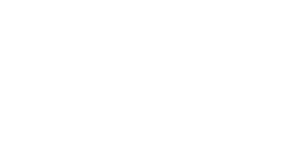

In [25]:
%matplotlib notebook

w_plot = 144 # 3 days
fontsize = 13

y_pred = y_pred_list[-2]

y_pred = y_pred.reshape(len(y_pred))

Residual = list(y_test) - y_pred

plt.figure(figsize=(8,3))
plt.plot(np.arange(0, (w_plot)), y_test[-w_plot:], label = 'Real values', linewidth = 1.5, color = 'steelblue')
plt.plot(np.arange(0, (w_plot)), y_pred[-w_plot:], label = 'Predicted values', linewidth = 1.2, color= 'deepskyblue')
plt.plot(np.arange(0, (w_plot)), Residual[-w_plot:], label = 'Residual error', linewidth = 0.8, color = 'slategrey')
plt.fill_between(np.arange(0, (w_plot)),  data['spike_lowerlim'][-w_plot:],data['spike_upperlim'][-w_plot:], facecolor='skyblue', alpha=0.5, label = 'Not spike regions')
plt.xlim(0, w_plot - 1)
plt.ylim(-100, 260)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Accumulated SP', fontsize = fontsize)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks([-100, -50, 0, 50,100, 150, 200, 250],[-100, -50, 0, 50, 100, 150, 200, 250],  fontsize = fontsize)
plt.title('Linear Regression predictions', fontsize = fontsize + 2)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig('2.png')